### Imports

In [1]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
import itertools
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv, Actions
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch

### Create Env

In [2]:
import os
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_50.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

In [3]:
%autoreload 2
from envs import MyForexEnv
env_name = 'MyForexEnv'
# df, window_size, frame_bound, unit_side='right', render_mode=None, **kwargs
env = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(10, int(len(FOREX_EURUSD_RENKO)*.95)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

### Define Functions

In [4]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []
    # profit_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        # total_profit = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                # if model is not None:
                #     total_profit = info[0]['total_profit']
                #     # print(f'Total Profit {total_profit}')
                # else: # random
                #     total_profit = info['total_profit']
                #     # print(f'Total Profit {total_profit}')
                break

        reward_over_episodes.append(total_reward)
        # profit_over_episodes.append(total_profit)
        # max_profit_over_episodes.append(total_max_profit)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes#, profit_over_episodes#

### Train + Test Env

In [5]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps) #, total_profit
min, avg, max = print_stats(rewards)
# min_tp, avg_tp, max_tp, = print_stats(total_profit)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
hyperparameters = {
    'lr': [1e-3, 1e-4, 1e-5], # Learning rate
    'gamma': [0.9, 0.95, 0.99], # Discount factor
    'ent_coef': [0.01, 0.05, 0.1] # Entropy coefficient
}
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))
best_hyperparameters = None
best_rewards = -np.inf

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for lr, gamma, ent_coef in hyperparameter_combinations:
        policy_dict = PPO.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = PPO(policy, env, verbose=0, learning_rate=lr, gamma=gamma, ent_coef=ent_coef)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key+'_lr_'+str(lr)+'_gamma_'+str(gamma)+'_ent_coef_'+str(ent_coef)
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps) #, total_profit , max_profit
            min, avg, max, = print_stats(rewards)
            # min_tp, avg_tp, max_tp, = print_stats(total_profit)
            # min_mp, avg_mp, max_mp, = print_stats(max_profit)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key} - lr:{lr} gamma:{gamma} ent_coef:{ent_coef}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}  
            if rewards > best_rewards:
                best_rewards = rewards
                best_hyperparameters = (lr, gamma, ent_coef)   
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : MyForexEnv
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: -310.189: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


Min. Reward          :   -310.189
Avg. Reward          :   -310.189
Max. Reward          :   -310.189
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [01:04, 413.13it/s]                            
Episode: 40, Avg. Reward: 380.378: 100%|██████████| 50/50 [42:55<00:00, 51.51s/it]


Min. Reward          :  -3964.938
Avg. Reward          :    525.096
Max. Reward          :   5085.010
ERROR: name 'best_performance' is not defined
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:57, 461.94it/s]                            
  0%|          | 0/50 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(f"Best hyperparameters: {best_hyperparameters} \nBest performance: {best_performance}")

### Plot Results

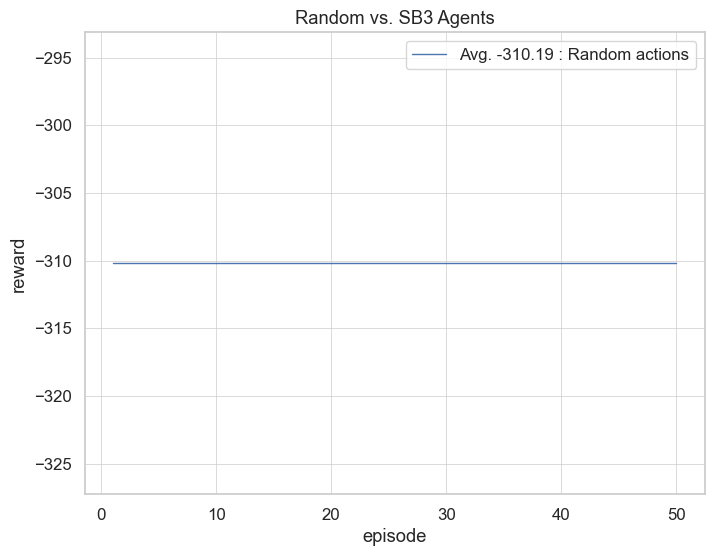

In [ ]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()